# Prospectus

_Imports, re-indexes by date, cleans, reduces, restricts by timeframe; permits regex pattern-matched purposive (Wave 1) and random (Wave 2) sampling and named entity redaction of PushShift .gzip Reddit archives for .csv annotation. Computes Cohen's Kappa post-annotation._

> bar_sample_annotate_iaa.ipynb<br>
> Simone J. Skeen (06-24-2024)

### Pre-annotation
***

In [1]:
#%pip install bertopic

!python -m spacy download en_core_web_lg --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import spacy
import warnings
import webbrowser

from collections import Counter
from google.colab import drive
from irrCAC.raw import CAC
from sklearn.metrics import cohen_kappa_score

spacy.cli.download('en_core_web_lg')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option(
              'display.max_columns',
              None,
              )
pd.set_option(
              'display.max_rows',
              None,
              )

warnings.simplefilter(
                      action = 'ignore',
                      category = FutureWarning,
                      )

#!python -m prodigy stats

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
drive.mount(
            '/content/gdrive/',
            force_remount = True,
            )

%cd gdrive/My Drive/Colab/prospectus/d_posts

Mounted at /content/gdrive/
/content/gdrive/My Drive/Colab/prospectus/d_posts


**_Import_**

In [5]:
wd = '/content/gdrive/MyDrive/Colab/prospectus/d_posts' ### Colab - gdrive

#wd = 'C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/d_posts' ### Jupyter - local

ds = []

# Loop over .json.gz

for filename in os.listdir(wd):
    if filename.endswith('.json.gz'):
        filepath = os.path.join(
                                wd,
                                filename,
                                )
        with gzip.open(
                       filepath,
                       'rt', ### 'open for reading', 'text mode'
                       encoding = 'utf-8',
                       ) as i:
            data = [json.loads(line) for line in i]
            d_gz = pd.DataFrame(data)
            ds.append(d_gz)

# Concatenate

d = pd.concat(
              ds,
              ignore_index = True,
              )

# Harmonize

d = d.dropna(
             axis = 1,
             how = 'any',
             )

# De-duplicate

d = d.drop_duplicates(
                      subset = 'id',
                      )

# Re-index

d['date'] = pd.to_datetime(
                           d.created_utc,
                           unit = 's',
                           )

d.set_index(
            'date',
            drop = False,
            inplace = True,
            )

# Inspect

d.shape
d.dtypes
d.sample(3)

(1459120, 16)

author                  object
created_utc             object
edited                  object
id                      object
is_self                   bool
media_embed             object
num_comments             int64
over_18                   bool
permalink               object
score                    int64
selftext                object
subreddit               object
subreddit_id            object
thumbnail               object
title                   object
date            datetime64[ns]
dtype: object

,author,created_utc,edited,id,is_self,media_embed,num_comments,over_18,permalink,score,selftext,subreddit,subreddit_id,thumbnail,title,date
date,,,,,,,,,,,,,,,,
2014-08-23 06:24:00,[deleted],1408775004,False,2ecj5x,True,{},3,False,/r/SuicideWatch/comments/2ecj5x/its_been_a_shi...,3,I only think about suicide when I have a run o...,SuicideWatch,t5_2qpzs,default,It's been a shitty few weeks.,2014-08-23 06:24:00
2014-04-25 17:27:28,8140_,1398446886,False,23yt4w,True,{},6,False,/r/SuicideWatch/comments/23yt4w/please_help_me...,1,Guys I'm really freaking out. I actually think...,SuicideWatch,t5_2qpzs,self,Please help me what else can I say,2014-04-25 17:27:28
2021-03-22 12:00:06,amnotroboto,1616414406,False,maltyf,True,{},20,False,/r/SuicideWatch/comments/maltyf/flashy_title_t...,76,I'm so fucking alone and I have absolutely nob...,SuicideWatch,t5_2qpzs,self,*flashy title that'll grab attention*,2021-03-22 12:00:06


**_Format_**

(424678, 20)

['SuicideWatch' 'Anxiety' 'depression' 'mentalhealth' 'trans'
 'TheGirlSurvivalGuide' 'TwoXChromosomes']


,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-03-01,[deleted],1646092800,2022-03-01,t3tuae,1,Anyone else have a corner in their room that ...,SuicideWatch,Corner,,,,,,,,,,,,


,p_au,p_utc,p_date,p_id,n_cmnt,text,sbrt,p_titl,asp,asp_rtnl,dep,dep_rtnl,val,val_rtnl,prg,tgd,age,race,dbty,insb
date,,,,,,,,,,,,,,,,,,,,
2022-12-30 23:55:55,GnGPanda,1672444555,2022-12-30 23:55:55,zzfkr9,8,I'm quite confused. My (28F) last period was e...,TwoXChromosomes,"Hurting breasts, no period, negative pregnancy...",,,,,,,,,,,,


<Axes: xlabel='date'>

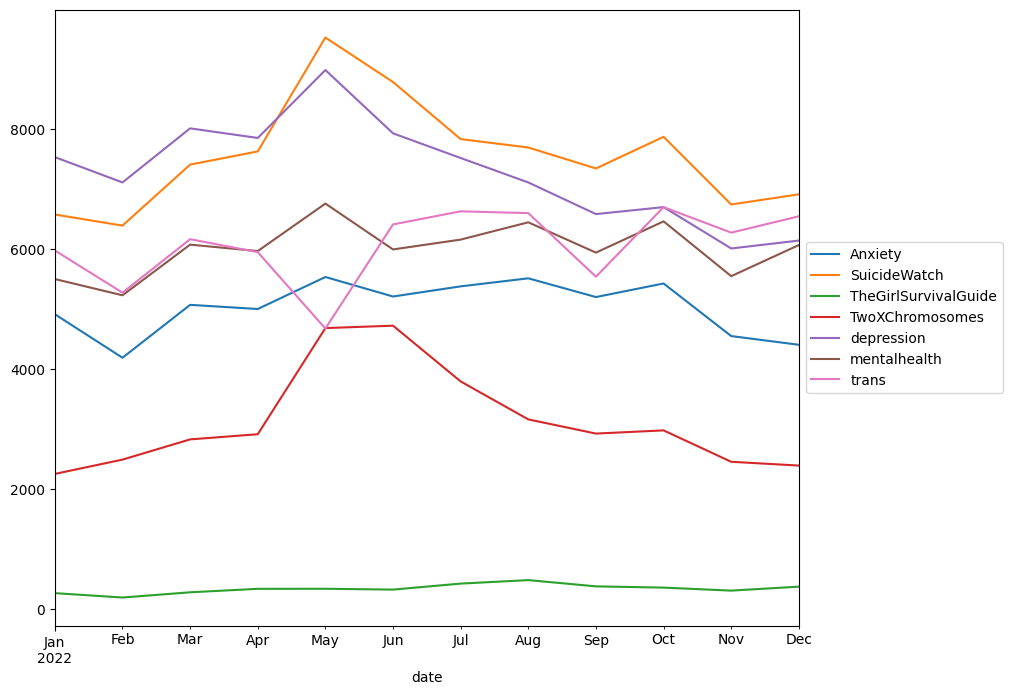

In [6]:
def d_prep(d):
    '''Prepares d for annotation'''
    d = d[[
           'author',
           'created_utc',
           'date',
           'id',
           'num_comments',
           'selftext',
           'subreddit',
           'title',
           ]].copy()

    d.rename(
             columns = {
                        'author': 'p_au',
                        'created_utc': 'p_utc',
                        'date': 'p_date',
                        'id': 'p_id',
                        'num_comments': 'n_cmnt',
                        'selftext': 'text',
                        'subreddit': 'sbrt',
                        'title': 'p_titl',
                        }, inplace = True,
            )

    d = d.assign(
                 asp = ' ',      ### STS
                 asp_rtnl = ' ',
                 dep = ' ',
                 dep_rtnl = ' ',
                 val = ' ',
                 val_rtnl = ' ',
                 prg = ' ',      ### explicit
                 tgd = ' ',
                 age = ' ',      ### hybrid
                 race = ' ',     ### implicit
                 dbty = ' ',
                 insb = ' ',     ### insubstantial
                 )

    d = d[~d['text'].isin([
                           '[deleted]',
                           '[removed]',
                           ])]

    return d

d = d_prep(d)

# Restrict timeframe

d = d.loc[(d['p_date'] >= '2022-01-01') & (d['p_date'] <= '2022-12-31')]

# Verify

d.shape
sbrt = d['sbrt'].unique()
print(sbrt)
d.head(1)
d.tail(1)

# Plot

monthly_counts = d.resample('M').sbrt.value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))

monthly_counts.plot(
                    kind = 'line',
                    ax = ax,
                    )

box = ax.get_position()

ax.set_position(
                [
                 box.x0,
                 box.y0,
                 box.width * 0.8,
                 box.height,
                 ]
                  )

ax.legend(
          loc = 'center left',
          bbox_to_anchor=(1, 0.5),
          )

plt.show()

**_Parse by subreddit_**

In [7]:
def d_parse(d, col):
    '''Parses d by subreddit'''
    uniq_val = d[col].unique()
    sub_d = {}
    for val in uniq_val:
        sub_d[f'd_{val}'] = d[d[col] == val].copy()

    return sub_d

sub_d = d_parse(
                d,
                'sbrt',
                )

**_Subset A: strains (proxy)_**

In [8]:
d_ax = sub_d['d_Anxiety']
d_dp = sub_d['d_depression']
d_mh = sub_d['d_mentalhealth']
d_sw = sub_d['d_SuicideWatch']

print('r/Anxiety')
d_ax.shape
print('\nr/depression')
d_dp.shape
print('\nr/mentalhealth')
d_mh.shape
print('\nr/SuicideWatch')
d_sw.shape

r/Anxiety


(60328, 20)


r/depression


(87403, 20)


r/mentalhealth


(72075, 20)


r/SuicideWatch


(90627, 20)

**_Subset B: explicit BAR targets (proxy)_**

In [9]:
d_gs = sub_d['d_TheGirlSurvivalGuide']
d_tr = sub_d['d_trans']
d_tx = sub_d['d_TwoXChromosomes']

print('r/TheGirlSurvivalGuide')
d_gs.shape
print('\nr/Trans')
d_tr.shape
print('\nr/TwoXChromosomes')
d_tx.shape

r/TheGirlSurvivalGuide


(4032, 20)


r/Trans


(72667, 20)


r/TwoXChromosomes


(37546, 20)

### Wave 1: purposive

**_Define <|PII|> redaction function_**

In [10]:
#import spacy

nlp = spacy.load('en_core_web_lg')

def redact(p_text):
    ne = list(
              [
               'PERSON',   ### people, including fictional
               'NORP',     ### nationalities or religious or political groups
               'FAC',      ### buildings, airports, highways, bridges, etc.
               'ORG',      ### companies, agencies, institutions, etc.
               #'GPE',     ### countries, cities, states
               'LOC',      ### non-GPE locations, mountain ranges, bodies of water
               'PRODUCT',  ### objects, vehicles, foods, etc. (not services)
               'EVENT',    ### named hurricanes, battles, wars, sports events, etc.
               ]
                )

    doc = nlp(p_text)
    ne_to_remove = []
    final_string = str(p_text)
    for sent in doc.ents:
        if sent.label_ in ne:
            ne_to_remove.append(str(sent.text))
    for n in range(len(ne_to_remove)):
        final_string = final_string.replace(
                                            ne_to_remove[n],
                                            '<|PII|>',
                                            )
    return final_string

#d['text'] = d['text'].astype(str).apply(lambda i: redact(i))

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


#### Cycle 0 (pilot)

**_r/SuicideWatch_**

In [ ]:
'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d = d.loc[d['text'].str.contains(
                                 rg,
                                 regex = True,
                                 )]

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))
d.shape

# Export: 'd_cycle*.xlsx'

os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_raw')
#%pwd

d.to_excel('d_cycle1.xlsx')

#### Cycle 1

**Subset A**<br>
r/Anxiety, r/Depression, r/MentalHealth, r/SuicideWatch

**Subset B**<br>
r/Trans

In [ ]:
d_a = pd.concat([
                 d_ax,
                 d_dp,
                 d_mh,
                 d_sw,
                 ])

d_a.reset_index(
                drop = True,
                inplace = True,
                )

d_b = d_tr.copy()

In [ ]:
# Subset A: r/anxiety, r/depression, r/mentalhealth, r/SuicideWatch

'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg_a = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d_a = d_a.loc[d_a['text'].str.contains(
                                       rg_a,
                                       regex = True,
                                       )]

d_a.shape

# Subset B: r/trans

'.criminal\S*|restrict\S*|.law|.legal\S*' ### a priori/canonical

rg_b = re.compile('.criminal\S*|restrict\S*|.law|.legal\S*', re.I)

d_b = d_b.loc[d_b['text'].str.contains(
                                       rg_b,
                                       regex = True,
                                       )]

d_b.shape

In [ ]:
d = pd.concat([
               d_a, # n = 9740
               d_b, # n = 1505
               ])

d.shape # N = 11245

**Export: 'd_cycle*.xlsx'**

In [ ]:
d = d.sample(n = 100)

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))
d.shape

# Export: 'd_cycle*.xlsx'

os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_raw')
#%pwd

d.to_excel('d_cycle1.xlsx')

####Cycle 2

**Subset A**<br>
r/Depression, r/SuicideWatch<br>

**Subset B**<br>
r/Trans

In [ ]:
d_a = pd.concat([
                 d_dp,
                 d_sw,
                 ])

        ### SJS 5/22: dropping r/Anxiety, r/mentalhealth

d_a.reset_index(
                drop = True,
                inplace = True,
                )

d_b = d_tr.copy()

In [ ]:
# Subset A

'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg_a = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d_a = d_a.loc[d_a['text'].str.contains(
                                       rg_a,
                                       regex = True,
                                       )]

d_a.shape

# Subset B

'.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*' ### a priori/canonical

rg_b = re.compile('.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*', re.I)

d_b = d_b.loc[d_b['text'].str.contains(
                                       rg_b,
                                       regex = True,
                                       )]

d_b.shape

In [ ]:
d = pd.concat([
               d_a, # n = 5602
               d_b, # n = 729
               ])

d.shape # N = 11245

**Export: 'd_cycle*.xlsx'**

In [ ]:
d = d.sample(n = 100)

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))

# Export: 'd_cycle*.xlsx'

os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_raw')
#%pwd

d.to_excel('d_cycle2.xlsx')

#### Cycle 3

**Subset A**<br>
r/Depression, r/SuicideWatch<br>

**Subset B**<br>
r/TheGirlsSurvivalGuide, r/Trans, r/TwoXChromosomes

In [11]:
d_a = pd.concat([
                 d_dp,
                 d_sw,
                 ])

d_a.reset_index(
                drop = True,
                inplace = True,
                )

d_b = pd.concat([
                 d_gs,
                 d_tr,
                 d_tx,
                 ])

d_b.reset_index(
                drop = True,
                inplace = True,
                )

In [12]:
# Subset A

'.gend\S*|pregnan\S*' ### a priori/canonical
'trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe' ### inductively derived

rg_a = re.compile('.gend\S*|pregnan\S*|trans|non-?binary|dysphor\S*|hormone|abort\S*|dobbs|roe', re.I)

d_a = d_a.loc[d_a['text'].str.contains(
                                       rg_a,
                                       regex = True,
                                       )]

d_a.shape

# Subset B

'.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*' ### a priori/canonical

rg_b = re.compile('.criminal\S*|restrict\S*|illegal\S*|outlaw\S*|suicid\S*', re.I)

d_b = d_b.loc[d_b['text'].str.contains(
                                       rg_b,
                                       regex = True,
                                       )]

d_b.shape

'.gend\\S*|pregnan\\S*'

'trans|non-?binary|dysphor\\S*|hormone|abort\\S*|dobbs|roe'

(5602, 20)

'.criminal\\S*|restrict\\S*|illegal\\S*|outlaw\\S*|suicid\\S*'

(1971, 20)

In [17]:
d = pd.concat([
               d_a, # n = 5602
               d_b, # n = 1971
               ])

d.shape # N = 7573

(7573, 20)

**Export: 'd_cycle*.xlsx'**

In [15]:
d = d.sample(n = 150)

d['text'] = d['text'].astype(str).apply(lambda i: redact(i))

#os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_raw')
#%pwd

%cd gdrive/My Drive/Colab/prospectus/annotation/d_raw

d.to_excel('d_cycle3.xlsx')

In [18]:
# Random subset - Cycle 999

d_999 = d.sample(n = 1000)

d_999['text'] = d_999['text'].astype(str).apply(lambda i: redact(i))

d_999.to_excel('d_cycle999.xlsx')

### Post-annotation
***

In [ ]:
# Import + calibrate

import numpy as np
import os
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from irrCAC.raw import CAC

from sklearn.metrics import cohen_kappa_score

pd.set_option('display.max_columns', None)

#!python -m prodigy stats

In [ ]:
# C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation

os.chdir('C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation')
#%pwd

sd = 'C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_cycle2_sd.xlsx'
d_sd = pd.read_excel(sd)
#d_sd.dtypes

#d_sd = d_sd.replace(' ', 0)
d_sd.columns = [f'{col}_sd' for col in d_sd.columns]

ss = 'C:/Users/sskee/OneDrive/Documents/02_tulane/01_research/03_prospectus/annotation/d_cycle2_ss.xlsx'
d_ss = pd.read_excel(ss)

#d_ss = d_ss.replace(' ', 0)
d_ss.columns = [f'{col}_ss' for col in d_ss.columns]

# Inspect

#d_sd.head(3)
#d_ss.head(3)

# Merge

d = pd.merge(
             d_sd,
             d_ss,
             left_index = True,
             right_index = True,
             )

targets = [
           'asp_sd', 'asp_ss',
           'dep_sd', 'dep_ss',
           'val_sd', 'val_ss',
           'prg_sd', 'prg_ss',
           'tgd_sd', 'tgd_ss',
           'age_sd', 'age_ss',
           'race_sd', 'race_ss',
           'dbty_sd', 'dbty_ss',
           'insb_sd', 'insb_ss',
            ]

#d = d[targets].copy()

d = d.fillna(0)
d = d.replace(' ', 0)
#d = d.apply(pd.to_numeric, errors='coerce')
d[targets] = d[targets].apply(
                              pd.to_numeric,
                              errors = 'coerce',
                              )

d = d[[
        #targets,
        'p_id_sd', 'p_id_ss', ### sense-check for bad merge
        'text_sd',
        'asp_sd', 'asp_ss',
        'asp_rtnl_sd', 'asp_rtnl_ss',
        'dep_sd', 'dep_ss',
        'dep_rtnl_sd', 'dep_rtnl_ss',
        'val_sd', 'val_ss',
        'val_rtnl_sd', 'val_rtnl_ss',
        'prg_sd', 'prg_ss',
        'tgd_sd', 'tgd_ss',
        'age_sd', 'age_ss',
        'race_sd', 'race_ss',
        'dbty_sd', 'dbty_ss',
        'insb_sd', 'insb_ss',
        ]].copy()

d.rename(
           columns = {
                      'p_id_sd': 'p_id',
                      'text_sd': 'text',
                      }, inplace = True,
          )

#d.to_excel('iaa_inspect.xlsx')

# Drop insb = 1 (either annotator)

d = d[(d['insb_sd'] != 1) & (d['insb_ss'] != 1)]

'n valid'
d.shape

# Convert to numpy array

#for target in targets:
#    target = d[target].to_numpy()

# Function to calculate Cohen's Kappa score for a pair of columns
def calculate_kappa(d, col_sd, col_ss):
    return cohen_kappa_score(d[col_sd], d[col_ss])

# List of column pairs to check
column_pairs = [
                ('asp_sd', 'asp_ss'),
                ('dep_sd', 'dep_ss'),
                ('val_sd', 'val_ss'),
                ('prg_sd', 'prg_ss'),
                ('tgd_sd', 'tgd_ss'),
                ('age_sd', 'age_ss'),
                ('race_sd', 'race_ss'),
                ('dbty_sd', 'dbty_ss'),
                ]

# Dictionary to store the results
kappa_results = {}

# Loop through the column pairs and calculate Cohen's Kappa score
for col_sd, col_ss in column_pairs:
    kappa = calculate_kappa(d, col_sd, col_ss)
    kappa_results[f'{col_sd} and {col_ss}'] = kappa

# Display the results
for pair, kappa in kappa_results.items():
    print(f"Cohen's Kappa for {pair}: {kappa:.2f}")


# Dummy code disagreements - inspection, triangulation

# Define the mismatch checking function

def d_disagree(row):
    return 1 if row[0] != row[1] else 0

# List of column pairs and corresponding new column names

sts_pairs = [('asp_sd', 'asp_ss', 'asp_dis'),
             ('dep_sd', 'dep_ss', 'dep_dis'),
             ('val_sd', 'val_ss', 'val_dis')]

# Iterate through each pair of columns
for col1, col2, dis_col in sts_pairs:
    # Apply the check_mismatch function row-wise and assign results to a new column
    d[dis_col] = d[[col1, col2]].apply(d_disagree, axis = 1)


d.to_excel('iaa_cycle1.xlsx')

> End of bar_sample_annotate_iaa.ipynb (04-17-2024)